In [1]:
from phase3_data import release
v3_release = release.release_data()

In [4]:
from cartopy.geodesic import Geodesic
import numpy as np
from itertools import combinations
import allel
import pandas as pd
import yaml

In [5]:
# reset index in this case
meta = v3_release.load_metadata_by_sampleset(v3_release.all_wild_samplesets).reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [6]:
meta.head()

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sampleset,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
0,AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
1,AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
2,AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
3,AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
4,AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [7]:
meta.is_arabiensis.value_counts()

False    2416
True      368
Name: is_arabiensis, dtype: int64

In [8]:
geo = Geodesic()

In [9]:
grp_loc = meta.groupby(["latitude", "longitude"])["latitude", "longitude"]

In [10]:
locations = meta[["latitude", "longitude"]].drop_duplicates()
locations

,latitude,longitude
0,-8.884,13.302
81,11.150,-4.235
83,11.233,-4.472
120,11.235,-4.535
364,12.060,-1.170
...,...,...
2364,-3.482,37.308
2403,-1.431,34.199
2450,-4.940,38.948
2494,0.770,34.026


In [11]:
condensed_dist_matrix = np.zeros((meta.shape[0] * (meta.shape[0] - 1))//2, dtype=np.float32)
condensed_dist_matrix.shape

(3873936,)

In [12]:
for a, b in combinations(range(locations.shape[0]), 2):
    
    ix = grp_loc.get_group(tuple(locations.iloc[a])).index.values
    jx = grp_loc.get_group(tuple(locations.iloc[b])).index.values
    
    coords  = allel.condensed_coords_between(ix, jx, meta.shape[0])    
    condensed_dist_matrix[coords] = geo.geometry_length(locations.iloc[[a, b]].values) * 1e-3

## Do some hierarchical clustering

In [13]:
from scipy.spatial.distance import _convert_to_double
import scipy.spatial.distance as distance


In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [15]:
import seaborn as sns

In [16]:
def plot_dendrogram(dist, nhaps, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # faff
    y = _convert_to_double(np.asarray(dist, order='c'))
    
    # 2. get n
    n = int(distance.num_obs_y(dist))
    
    # 3. do clustering
    #method = dict(single=0, complete=1)[method]
    z = linkage(y, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=color_threshold, 
        above_threshold_color=above_threshold_color,
        ax=ax)
    
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, nhaps, 200)) + [nhaps])
    
    xticks = xticklabels / nhaps
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Samples')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-0.0001)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('km')

    ax.autoscale(axis='x', tight=True)
    return z, r

In [17]:
def make_color_bar(meta, variable, ax, ix):
    
    reordered_frame = meta.iloc[ix]
    print(reordered_frame.shape)
    
    
    values = pd.Categorical(reordered_frame[variable])
    print(values.value_counts())
    
    pal = sns.color_palette("hls", values.codes.max() + 1)
        
    clrs = dict(zip(values.categories, pal))
    print(clrs)
    
    ax.broken_barh(
        xranges=[(i, 1) for i in range(reordered_frame.shape[0])], 
        yrange=(0, 1), 
        color=[clrs[v] for v in values])
    
    sns.despine(ax=ax, offset=5, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, reordered_frame.shape[0])
    ax.yaxis.set_label_position('left')
    ax.set_ylabel(variable, rotation=0, ha='right', va='center')
    
    return clrs, values

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

/opt/conda/lib/python3.7/site-packages/seaborn/utils.py:247: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  maj_on = any(t.tick1On for t in ax_i.xaxis.majorTicks)
/opt/conda/lib/python3.7/site-packages/seaborn/utils.py:248: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  min_on = any(t.tick1On for t in ax_i.xaxis.minorTicks)
/opt/conda/lib/python3.7/site-packages/seaborn/utils.py:251: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = maj_on
/opt/conda/lib/python3.7/site-packages/seaborn/utils.py:253: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2

(2784, 19)
Angola                           81
Burkina Faso                    296
Cameroon                        444
Central African Republic         73
Cote d'Ivoire                    80
Democratic Republic of Congo     76
Equatorial Guinea                10
Gabon                            69
Gambia, The                     279
Ghana                           100
Guinea                          136
Guinea-Bissau                   101
Kenya                            86
Malawi                           41
Mali                            225
Mayotte                          23
Mozambique                       74
Tanzania                        300
Uganda                          290
dtype: int64
{'Angola': (0.86, 0.3712, 0.33999999999999997), 'Burkina Faso': (0.86, 0.5354105263157893, 0.33999999999999997), 'Cameroon': (0.86, 0.6996210526315789, 0.33999999999999997), 'Central African Republic': (0.8561684210526316, 0.86, 0.33999999999999997), "Cote d'Ivoire": (0.6919578947368422, 0.8

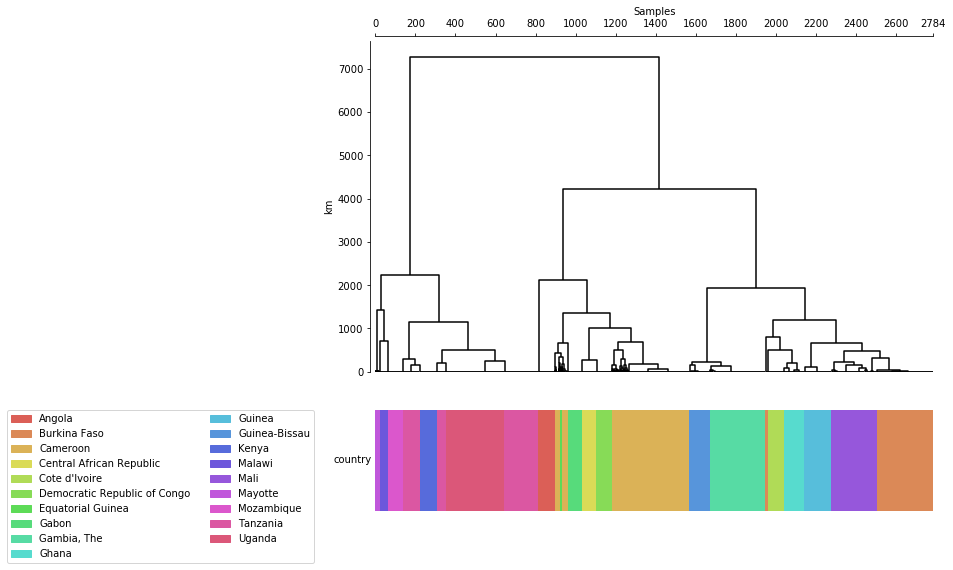

In [19]:
fig = plt.figure(figsize=(10, 14))
gs = GridSpec(4, 1, height_ratios=(3, 1, 1, 1), )

ax1 = plt.subplot(gs[0])
zz, rr = plot_dendrogram(condensed_dist_matrix, meta.shape[0], ax1)

for i, x in enumerate(["country", "species_label"]):
    ax2 = plt.subplot(gs[i + 1])
    col_dict, v = make_color_bar(
        meta, 
        x, 
        ax2,
        rr["leaves"])
    
    handles = [
        mpl.patches.Patch(
            color=v, label=k) for k, v in col_dict.items()]

    ax2.legend(
        handles=handles, 
        loc=0, 
        bbox_to_anchor=(-0.1, 1), ncol=2)
    
    break

In [20]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n=None, threshold=1000):
    
    # find clusters
    f = fcluster(z, threshold, criterion='distance')
    
    # compute cluster sizes
    fsz = np.bincount(f)
    
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    
    # take largest n
    if n is not None:
        fsort = fsort[:n]
    
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    
    return clusters


In [21]:
c = find_clusters(zz, threshold=250)

In [22]:
len(c)

27

In [23]:
meta.loc[c[0]].country.value_counts()

Gambia, The      279
Guinea-Bissau    101
Name: country, dtype: int64

In [24]:
meta.country.value_counts()

Cameroon                        444
Tanzania                        300
Burkina Faso                    296
Uganda                          290
Gambia, The                     279
Mali                            225
Guinea                          136
Guinea-Bissau                   101
Ghana                           100
Kenya                            86
Angola                           81
Cote d'Ivoire                    80
Democratic Republic of Congo     76
Mozambique                       74
Central African Republic         73
Gabon                            69
Malawi                           41
Mayotte                          23
Equatorial Guinea                10
Name: country, dtype: int64

In [25]:
meta["cluster_id"] = "NA"

In [26]:
for index, clust in enumerate(c):
    print(index, meta.loc[clust].country.value_counts())
    meta["cluster_id"].loc[clust] = f"cluster_{index}"
    print(" ")

0 Gambia, The      279
Guinea-Bissau    101
Name: country, dtype: int64
 
1 Cameroon    303
Name: country, dtype: int64
 
2 Burkina Faso    283
Name: country, dtype: int64
 
3 Tanzania    170
Uganda       96
Name: country, dtype: int64
 
4 Uganda      194
Tanzania     47
Name: country, dtype: int64
 
5 Mali    197
Name: country, dtype: int64
 
6 Guinea    136
Name: country, dtype: int64
 
7 Kenya       86
Tanzania    43
Name: country, dtype: int64
 
8 Ghana    100
Name: country, dtype: int64
 
9 Angola    81
Name: country, dtype: int64
 
10 Cote d'Ivoire    80
Name: country, dtype: int64
 
11 Democratic Republic of Congo    76
Name: country, dtype: int64
 
12 Mozambique    74
Name: country, dtype: int64
 
13 Central African Republic    73
Name: country, dtype: int64
 
14 Gabon    69
Name: country, dtype: int64
 
15 Malawi    41
Name: country, dtype: int64
 
16 Cameroon    41
Name: country, dtype: int64
 
17 Tanzania    40
Name: country, dtype: int64
 
18 Cameroon    30
Name: country, d

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
pd.crosstab(meta.cluster_id, meta.country)

country,Angola,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Equatorial Guinea,Gabon,"Gambia, The",Ghana,Guinea,Guinea-Bissau,Kenya,Malawi,Mali,Mayotte,Mozambique,Tanzania,Uganda
cluster_id,,,,,,,,,,,,,,,,,,,
cluster_0,0,0,0,0,0,0,0,0,279,0,0,101,0,0,0,0,0,0,0
cluster_1,0,0,303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cluster_10,0,0,0,0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cluster_11,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0,0,0,0,0
cluster_12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74,0,0
cluster_13,0,0,0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cluster_14,0,0,0,0,0,0,0,69,0,0,0,0,0,0,0,0,0,0,0
cluster_15,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0
cluster_16,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
centroids = meta.groupby("cluster_id").agg({"latitude": np.mean, "longitude": np.mean})

In [29]:
centroids.to_csv("../data/cluster_centroids.csv")

In [30]:
meta[["sample_id", "cluster_id"]].to_csv("../data/cluster_defs.csv", index=False)